# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

* Сразу добавил расстояние от цента Манхеттена в метрах
* Попробовал различные виды энкодеров для категориальных признаков. OneHot хуже чем LabelEncoder
* Попробовал заменить reviews_per_month на -1 и -999. Никакой разницы в RSME
* Попровал различные варианты скейлера - попробовал без скейлинга, с RobustScaler и StandardScaler. Лучший результат с RobustScaler
* Подобрал параметры LGBMRegressor (random_state=42, n_estimators=200, max_depth=20) - с помощью GridSearchCV. Довёл RSME до 70
* Удалил строки со значением цена = 0. Стало значительно лучше - RSME с 67 опустился до 65
* Удалил строки с ценой отличающейся на n сигма. Сделал это в зависимости от room_type и neighbourhood. Т.е. среднее и стандартное отклонение смотрел для каждой соответствующей выборки neighbourhood-room_type. Стало сильно лучше - RSME = 67. Попробовал различные значения. Если взять сигма = 1, то станет ещё лучше. Но это видимо уже не показательно, т.к. сокращается датасет
* RSME дополнительно посмотрел в зависимости от ценового сегмента (значения целевой переменной). Это более адекватно показывает качество модели
* Удалил записи с ценой меньше мин и больше макс. Если взять максимальную цену 500 USD, то получается очень хороший показатель RSME = 44. Больше 500 евро критически мало записей, поэтому строить на них модель нецелесообразно
* Нашёл, что распределение цены имеет очень интересный характер. БОльшее количество предложений сосредоточены вокруг цен кратных 5, 10, 50, 100 (колечество растёт в этом же порядке). Попробовал в качестве цели использовать цену в единицах 5, 10 и т.д. USD, т.к. для этого модель предположительно может обладать меньшей точностью, но должна показывать хороший результат на выходе. Ожидания не оправдались, это не улучшило прогноз
* Интересен порядок признаков по уровню влияния на цену
    1. room_type
    2. man_dist
    3. calculated_host_listing_count
    4. neighbourhood - я сначала думал что здесь самое большое влияние, после room_type
* Попробовал удалять постепенно не влияющие признаки и смотрел на изменение качества модели. Без снижения качества прогноза можно удалить признаки number_of_reviews и neighbourhood_group. Но это не повышает качество прогноза.
* К сожалению качество прогноза осталось посредственным. Для основных ценовых сегментов:

    RMSE:                                             43 , Мин цена:  16 , Макс цена:  500 , Кол:  13602
  
    RMSE 1 (в ценовом диапазоне до 50 USD):           24 , Мин цена:  16 , Макс цена:  50 , Кол:  1980
  
    RMSE 2 (в ценовом диапазоне от 50 до 150 USD):    34 , Мин цена:  51 , Макс цена:  150 , Кол:  8145
  
    RMSE 3 (в ценовом диапазоне от 150 до 500 USD):   64 , Мин цена:  151 , Макс цена:  500 , Кол:  3477
  


In [684]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем датасет с помощью Pandas
data = pd.read_csv('AB_NYC_2019.csv')

# Устанавливаем параметры обработки датасета
TR_MAN_DIST = 1 # преобразуем man_dist в значения 100, 200 ... 1000, 1500 ...

min_price = 13  # убираем значения меньше этой цены
max_price = 500 # убираем значения больше этой цены

# feat1 = 'neighbourhood' # признак1 для получения локальных выборок для поиска выбросов
feat1 = 'man_dist'  # признак1 для получения локальных выборок для поиска выбросов. Если TR_MAN_DIST = 0, то НЕ ИСПОЛЬЗОВАТЬ
feat2 = 'room_type' # признак2 для получения локальных выборок для поиска выбросов
n_sigma = 1.9   # убираем выбросы в выборках по man_dist и room_type
X_COUNT = 10    # в предыдущем пункте ещё учитываем что если в выборке меньше X_COUNT элементов, то не трогаем её

descr = 1       # попытка масштабировать целевое значение кратно 5, 10, 50, 100

add_cols_to_drop = []
# ['minimum_nights', 'number_of_reviews', 'availability_365', 'neighbourhood_group', 'neighbourhood']
add_cols_to_drop = ['number_of_reviews', 'neighbourhood_group']

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      48895
Признаков:    16
Мин цена:     0
Макс цена:    10000


In [685]:
# Добавляем расстояние от центра Манхэттена в метрах
man_center = data[data['neighbourhood_group'] == 'Manhattan'][['latitude', 'longitude']].mean()
man_lat, man_lon = man_center['latitude'], man_center['longitude']
# перевод разницы координат в метры
data['man_dist'] = np.sqrt(
    ((data['latitude'] - man_lat) * 111_000) ** 2 +
    ((data['longitude'] - man_lon) * 85_000) ** 2
).astype(int)

# Преобразуем man_dist
if TR_MAN_DIST == 1:
    mask = data['man_dist'] <= 1000
    data.loc[mask, 'man_dist'] = np.ceil(data.loc[mask, 'man_dist'] / 100) * 100
    mask = (data['man_dist'] > 1000) & (data['man_dist'] <= 3000)
    data.loc[mask, 'man_dist'] = np.ceil(data.loc[mask, 'man_dist'] / 500) * 500
    mask = (data['man_dist'] > 3000) & (data['man_dist'] <= 10000)
    data.loc[mask, 'man_dist'] = np.ceil(data.loc[mask, 'man_dist'] / 1000) * 1000
    mask = data['man_dist'] > 10000
    data.loc[mask, 'man_dist'] = np.ceil(data.loc[mask, 'man_dist'] / 5000) * 5000

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      48895
Признаков:    17
Мин цена:     0
Макс цена:    10000


In [686]:
# Кодируем категориальные признаки room_type, neighbourhood_group, neighbourhood
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['room_type'] = le.fit_transform(data['room_type'])
data['neighbourhood'] = le.fit_transform(data['neighbourhood'])
data['neighbourhood_group'] = le.fit_transform(data['neighbourhood_group'])

# data = pd.get_dummies(data, columns=['room_type', 'neighbourhood', 'neighbourhood_group'], drop_first=True)
#
# data.columns = (
#     data.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)  # заменяем всё "лишнее" на подчёркивание
# )

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      48895
Признаков:    17
Мин цена:     0
Макс цена:    10000


In [687]:
# Отрезаем лишние колонки
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'latitude', 'longitude']
data = data.drop(columns=cols_to_drop)
data = data.drop(columns=add_cols_to_drop)

# Заполняем NoN в reviews_per_month
data['reviews_per_month'] = data['reviews_per_month'].fillna(-1)

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      48895
Признаков:    8
Мин цена:     0
Макс цена:    10000


In [688]:
# Удаляем строки с значением цены = 0
mask = data['price'] == 0
data = data.drop(data[mask].index)

print('Записей: ', data.shape[0])
print('Признаков: ', data.shape[1])
print('Мин цена: ', data['price'].min())
print('Макс цена: ', data['price'].max())

Записей:  48884
Признаков:  8
Мин цена:  10
Макс цена:  10000


In [689]:
# Убираем строки с выбросами по цене. Их мало, но они влияют на качество модели в худшую сторону
mask = (data['price'] > max_price) | (data['price'] < min_price)
data = data.drop(data[mask].index)

# # Убираем строки с отклонениями цены более n сигмы
# n_sigma = 4
# mask = data['price'] < mean - n_sigma * std
# data = data.drop(data[mask].index)

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      47816
Признаков:    8
Мин цена:     13
Макс цена:    500


In [690]:
# Убираем строки с отклонениями цены более n сигмы (с учётом района, типа и категории жилья)

list_1 = sorted(list(data[feat1].unique()))
list_2 = sorted(list(data[feat2].unique()))

for i in list_1:
    for j in list_2:
        count = data[(data[feat1] == i) & (data[feat2] == j)].shape[0]
        if count > X_COUNT:
            mask = (data[feat1] == i) & (data[feat2] == j)
            mean = int(data[mask]['price'].mean())

            mask = (data[feat1] == i) & (data[feat2] == j)
            std = data[mask]['price'].std()
            std = int(np.nan_to_num(std, nan=0))

            mask = (data[feat1] == i) & (data[feat2] == j) & (data['price'] > mean + n_sigma * std)
            data = data.drop(data[mask].index)

            mask = (data[feat1] == i) & (data[feat2] == j) & (data['price'] < mean - n_sigma * std)
            data = data.drop(data[mask].index)

            # print(i, j, count, mean, std)

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      45338
Признаков:    8
Мин цена:     13
Макс цена:    500


In [691]:
data.head()

,neighbourhood,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,man_dist
1,127,0,225,1,0.38,2,355,1500
2,94,1,150,3,-1.00,1,365,6000
3,41,0,89,1,4.64,1,194,9000
4,61,0,80,10,0.10,1,0,5000
5,137,0,200,3,0.59,1,129,2000


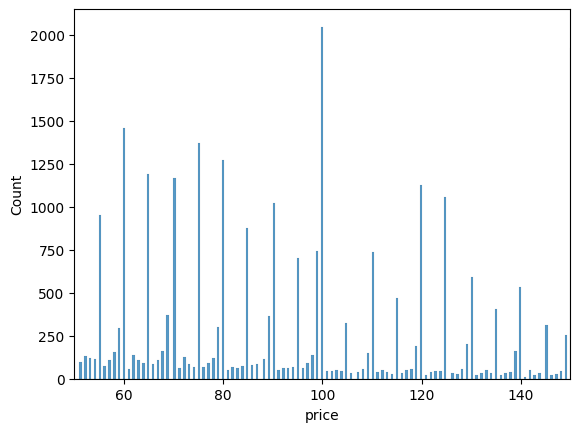

In [692]:
# Проанализируем распределение признаков

sns.histplot(data=data, x='price', bins=1000)
plt.xlim(50, 150)
# plt.ylim(0, 100)
plt.show()

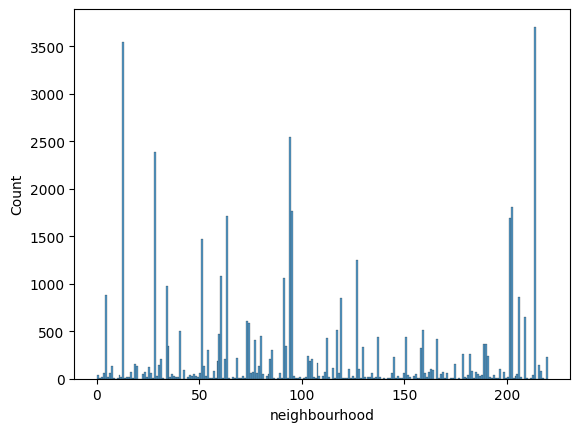

In [693]:
sns.histplot(data=data, x='neighbourhood', bins=230)
plt.show()

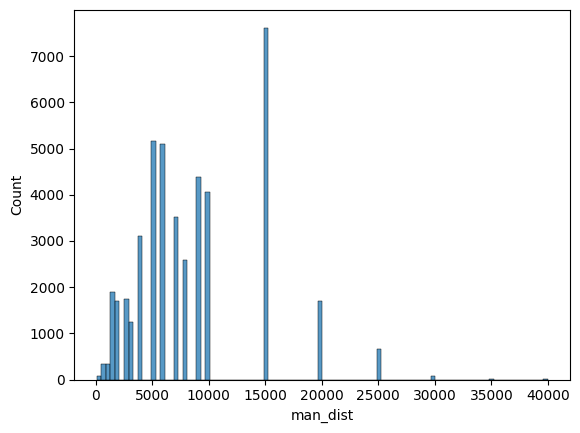

In [694]:
sns.histplot(data=data, x='man_dist', bins=100)
plt.show()

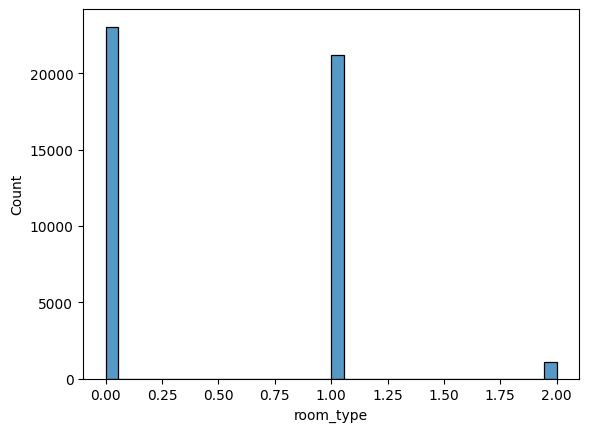

In [695]:
sns.histplot(data=data, x='room_type')
plt.show()

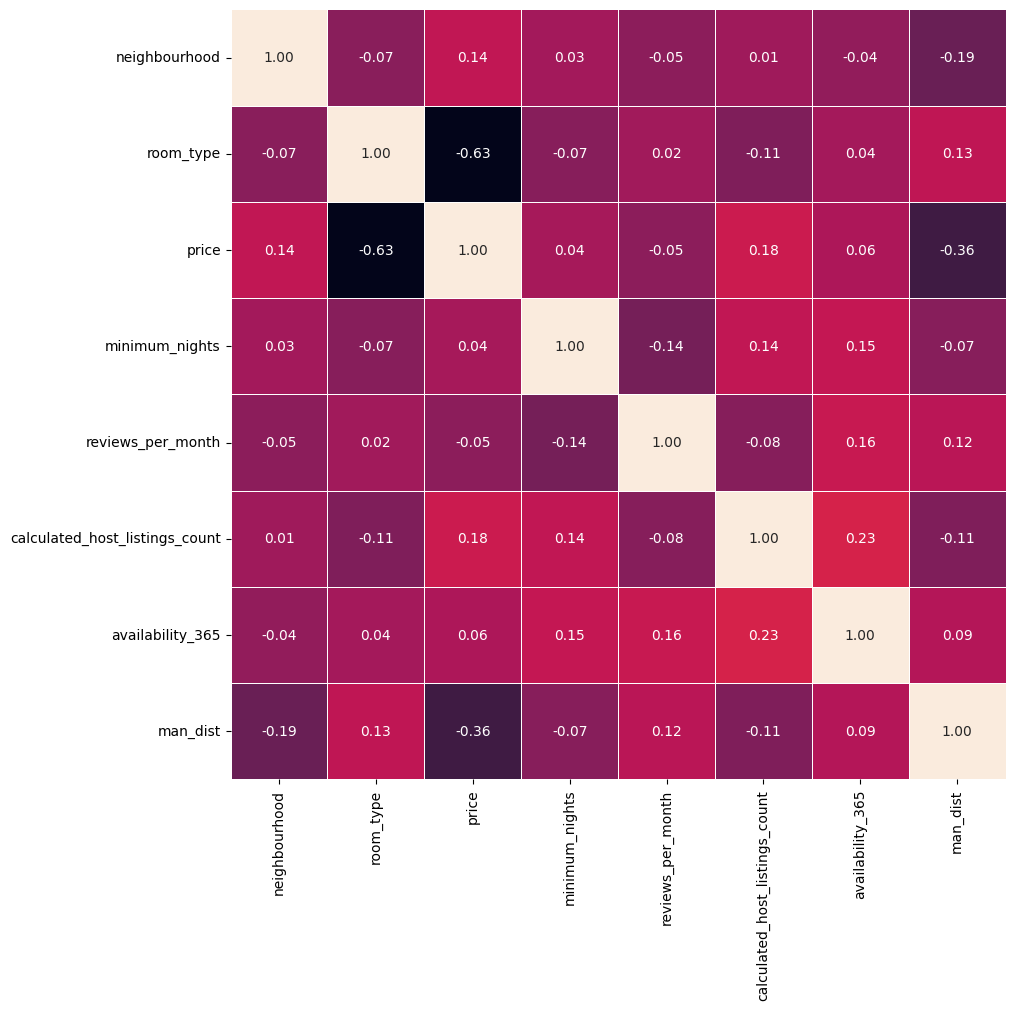

In [696]:
# Посмотрим на Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

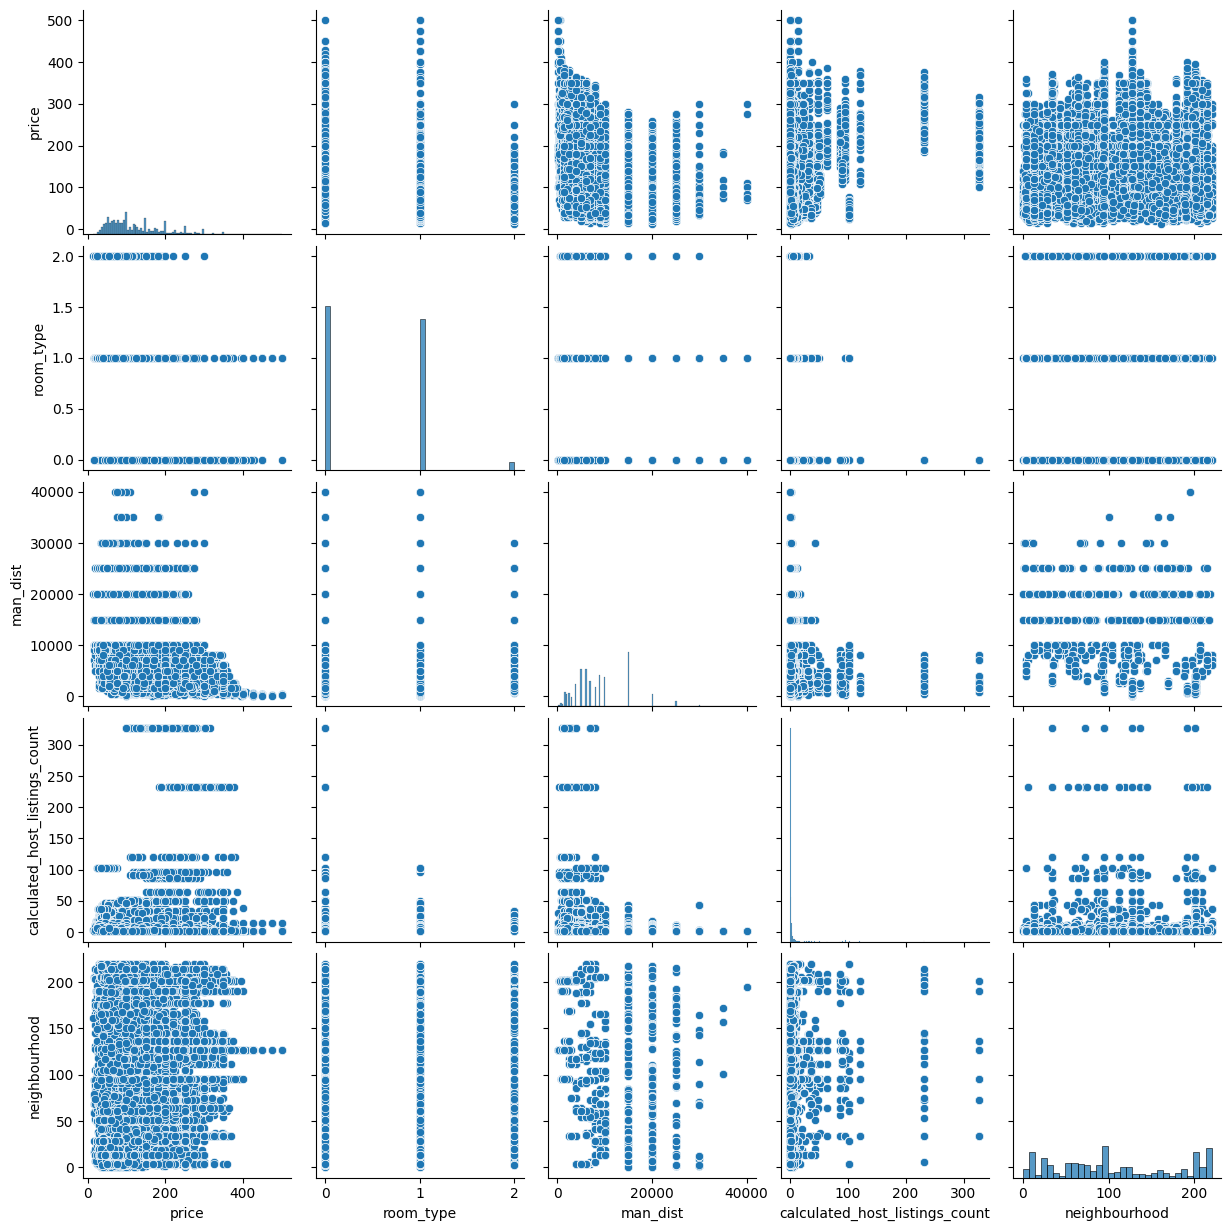

In [697]:
# Посмотрим более внимательно на коррелирующие поля
sns.pairplot(
    data,
    vars=['price', 'room_type', 'man_dist', 'calculated_host_listings_count', 'neighbourhood'],  # только эти переменные
)

In [698]:
# Берём за единицу цены n USD, т.к. в датасете видно, что основная масса цен кратна 5, 10, 50, 100
data['price_descr'] = (data['price'] / descr).round()

print('Записей:     ', data.shape[0])
print('Признаков:   ', data.shape[1])
print('Мин цена:    ', data['price'].min())
print('Макс цена:   ', data['price'].max())

Записей:      45338
Признаков:    9
Мин цена:     13
Макс цена:    500


In [699]:
# Разбиваем датасет на train и test, со стратификацией. Готовим датасеты для Классификатор и для Регрессора
from sklearn.model_selection import train_test_split

# strat_col = data['neighbourhood'].astype(str) + "_" + data['room_type'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    # data.drop(columns=price),
    data.drop('price', axis=1),
    data['price'],
    test_size=0.30,
    random_state=100,
    # stratify=strat_col
)

X_train_Price_descr = X_train['price_descr']
X_test_Price_descr = X_test['price_descr']
X_train = X_train.drop('price_descr', axis=1)
X_test = X_test.drop('price_descr', axis=1)

y_train = X_train_Price_descr


In [700]:
# Приводим значения признаков к одному масштабу. Попробовал без скейлинга, с RobustScaler и StandardScaler. Лучший результат с RobustScaler
from sklearn.preprocessing import RobustScaler

# Свой Scaler который возвращает типы Pandas
class MyScaler(RobustScaler):
    def transform(self, X, *args, **kwargs):
        X_scaled = super().transform(X, *args, **kwargs)
        return pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    def fit_transform(self, X, *args, **kwargs):
        X_scaled = super().fit_transform(X, *args, **kwargs)
        return pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

scaler = MyScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [701]:
# Обучаем регрессор предсказывать цену на датасете
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Параметры нашёл с помощью GridSearchCV
model = LGBMRegressor(random_state=42, n_estimators=200, max_depth=20)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 31736, number of used features: 7
[LightGBM] [Info] Start training from score 120.467923


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,20
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [702]:
# Проверяем метрики обученной модели. Посчитаем RMSE

y_test_Predictions = descr * model.predict(X_test)

mask1 = y_test <= 50
mask2 = (y_test <= 150) & (y_test > 50)
mask3 = (y_test <= 500) & (y_test > 150)
mask4 = y_test > 500

rmse = round(np.sqrt(mean_squared_error(y_test, y_test_Predictions)))
rmse1 = round((np.sqrt(mean_squared_error(y_test[mask1], y_test_Predictions[mask1])) if len(y_test[mask1]) > 0 else 0))
rmse2 = round((np.sqrt(mean_squared_error(y_test[mask2], y_test_Predictions[mask2])) if len(y_test[mask2]) > 0 else 0))
rmse3 = round((np.sqrt(mean_squared_error(y_test[mask3], y_test_Predictions[mask3])) if len(y_test[mask3]) > 0 else 0))
rmse4 = round((np.sqrt(mean_squared_error(y_test[mask4], y_test_Predictions[mask4])) if len(y_test[mask4]) > 0 else 0))

pmin, pmax, count = y_test.min(), y_test.max(), len(y_test)
pmin1, pmax1, count1 = y_test[mask1].min(), y_test[mask1].max(), len(y_test[mask1])
pmin2, pmax2, count2 = y_test[mask2].min(), y_test[mask2].max(), len(y_test[mask2])
pmin3, pmax3, count3 = y_test[mask3].min(), y_test[mask3].max(), len(y_test[mask3])
pmin4, pmax4, count4 = y_test[mask4].min(), y_test[mask4].max(), len(y_test[mask4])

print('------------------------------------------------------------')
print("RMSE:                                            ", rmse, ', Мин цена: ', pmin, ', Макс цена: ', pmax, ', Кол: ', count)
print("RMSE 1 (в ценовом диапазоне до 50 USD):          ", rmse1, ', Мин цена: ', pmin1, ', Макс цена: ', pmax1, ', Кол: ', count1)
print("RMSE 2 (в ценовом диапазоне от 50 до 150 USD):   ", rmse2, ', Мин цена: ', pmin2, ', Макс цена: ', pmax2, ', Кол: ', count2)
print("RMSE 3 (в ценовом диапазоне от 150 до 500 USD):  ", rmse3, ', Мин цена: ', pmin3, ', Макс цена: ', pmax3, ', Кол: ', count3)
print("RMSE 4 (в ценовом диапазоне от 500 USD):         ", rmse4, ', Мин цена: ', pmin4, ', Макс цена: ', pmax4, ', Кол: ', count4)

------------------------------------------------------------
RMSE:                                             43 , Мин цена:  16 , Макс цена:  500 , Кол:  13602
RMSE 1 (в ценовом диапазоне до 50 USD):           24 , Мин цена:  16 , Макс цена:  50 , Кол:  1980
RMSE 2 (в ценовом диапазоне от 50 до 150 USD):    34 , Мин цена:  51 , Макс цена:  150 , Кол:  8145
RMSE 3 (в ценовом диапазоне от 150 до 500 USD):   64 , Мин цена:  151 , Макс цена:  500 , Кол:  3477
RMSE 4 (в ценовом диапазоне от 500 USD):          0 , Мин цена:  nan , Макс цена:  nan , Кол:  0
